<a href="https://colab.research.google.com/github/jhivandebenoit/Melanoma_Detection/blob/master/Melanoma_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle
!pip install tensorflow
import tensorflow as tf
print(tf.__version__)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(len(physical_devices))

In [ ]:
!pip install livelossplot
!pip install keras_applications
!pip install opencv-python
!pip install tensorflow-addons

     |████████████████████████████████| 50 kB 2.9 MB/s 
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3021, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/base_command.py", line 180, in _main
    status = self.run(options, args)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/req_command.py", line 199, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py", line 385, in run
    conflicts = self._determine_conflicts(to_install)
  File "/

In [ ]:
!pip install -q kaggle

In [ ]:
# from google.colab import files 
# files.upload()

In [ ]:
!mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json


In [ ]:
! kaggle datasets list


ref                                                            title                                              size  lastUpdated          downloadCount  
-------------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
yasserh/wine-quality-dataset                                   Wine Quality Dataset                               21KB  2022-01-15 19:15:11           6028  
prasertk/netflix-subscription-price-in-different-countries     Netflix subscription fee in different countries     3KB  2022-01-15 07:06:09           4870  
prasertk/the-best-cities-for-a-workation                       The Best Cities for a Workation                     6KB  2022-02-16 11:46:28            498  
majyhain/height-of-male-and-female-by-country-2022             Height of Male and Female by Country 2022           4KB  2022-02-02 00:40:19           2234  
sanjeetsinghnaik/top-1000-highest-grossing-movies         

In [ ]:
!kaggle datasets download -d nroman/melanoma-external-malignant-256


 99% 1.00G/1.01G [00:31<00:00, 47.3MB/s]
100% 1.01G/1.01G [00:32<00:00, 33.9MB/s]


In [ ]:
! mkdir datasets

In [ ]:
! unzip melanoma-external-malignant-256.zip -d datasets

Streaming output truncated to the last 5000 lines.
  inflating: datasets/train/train/ISIC_8513112.jpg  
  inflating: datasets/train/train/ISIC_8513649.jpg  
  inflating: datasets/train/train/ISIC_8514170.jpg  
  inflating: datasets/train/train/ISIC_8514989.jpg  
  inflating: datasets/train/train/ISIC_8515165.jpg  
  inflating: datasets/train/train/ISIC_8515281.jpg  
  inflating: datasets/train/train/ISIC_8515582.jpg  
  inflating: datasets/train/train/ISIC_8515674.jpg  
  inflating: datasets/train/train/ISIC_8516181.jpg  
  inflating: datasets/train/train/ISIC_8516223.jpg  
  inflating: datasets/train/train/ISIC_8516516.jpg  
  inflating: datasets/train/train/ISIC_8516631.jpg  
  inflating: datasets/train/train/ISIC_8516659.jpg  
  inflating: datasets/train/train/ISIC_8516922.jpg  
  inflating: datasets/train/train/ISIC_8517305.jpg  
  inflating: datasets/train/train/ISIC_8517492.jpg  
  inflating: datasets/train/train/ISIC_8518406.jpg  
  inflating: datasets/train/train/ISIC_8519222.j

In [ ]:
import numpy as np
import pandas as pd
import cv2
from livelossplot import PlotLossesKeras
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten,BatchNormalization,Activation
from keras.layers import GlobalMaxPooling2D
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras import backend as K
import sklearn.metrics as metrics
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

In [ ]:
train_dir='/content/datasets/train/train/'
test_dir='/content/datasets/test/test/'
train_df=pd.read_csv('/content/datasets/train_concat.csv')
test_df=pd.read_csv('/content/test.csv')
submission=pd.read_csv('/content/sample_submission.csv')

In [ ]:
train_df.head()


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,0


In [ ]:
train_df['anatom_site_general_challenge'].value_counts()

torso              16845
lower extremity     9213
upper extremity     5707
head/neck           2735
anterior torso      1331
palms/soles          576
posterior torso      430
oral/genital         143
lateral torso         14
Name: anatom_site_general_challenge, dtype: int64

In [ ]:
train_df['target'].value_counts()

0    32542
1     5106
Name: target, dtype: int64

In [ ]:
#Taking a sample from the dataset
benign_df = train_df[train_df['target']==0].sample(5000)
malignant_df = train_df[train_df['target']==1].sample(5000)

In [ ]:
train_df=pd.concat([benign_df,malignant_df])
train_df=train_df.reset_index() #stop old index being added as a column
train_df.head()

,index,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,target
0,7600,ISIC_2374434,IP_0961415,male,45.0,lower extremity,0
1,20046,ISIC_6090684,IP_6977878,male,45.0,torso,0
2,7146,ISIC_2232546,IP_2442926,female,65.0,upper extremity,0
3,23740,ISIC_7207977,IP_8349207,male,50.0,torso,0
4,27916,ISIC_8447662,IP_0148851,female,60.0,lower extremity,0


In [ ]:
#Creating dataframe of image addresses with their labels
labels=[]
train_data=[]
for i in range(train_df.shape[0]):
    train_data.append(train_dir + train_df['image_name'].iloc[i]+'.jpg')
    labels.append(train_df['target'].iloc[i])
df=pd.DataFrame(train_data)
df.columns=['images']
df['target']=labels
df.head()

,images,target
0,/content/datasets/train/train/ISIC_2374434.jpg,0
1,/content/datasets/train/train/ISIC_6090684.jpg,0
2,/content/datasets/train/train/ISIC_2232546.jpg,0
3,/content/datasets/train/train/ISIC_7207977.jpg,0
4,/content/datasets/train/train/ISIC_8447662.jpg,0


In [ ]:
# Creating df of image addresses for testing, no labels
test_data=[]
for i in range(test_df.shape[0]):
   test_data.append(test_dir + test_df['image_name'].iloc[i]+'.jpg')
test_df=pd.DataFrame(test_data)
test_df.columns=['images']
test_df.head()

,images
0,/content/datasets/test/test/ISIC_0052060.jpg
1,/content/datasets/test/test/ISIC_0052349.jpg
2,/content/datasets/test/test/ISIC_0058510.jpg
3,/content/datasets/test/test/ISIC_0073313.jpg
4,/content/datasets/test/test/ISIC_0073502.jpg


In [ ]:
#Splitting Labeled data for train/val
from  sklearn.model_selection import train_test_split
x_train, x_val,y_train,y_val = train_test_split(df['images'],df['target'],test_size = 0.15, random_state = 1)
train_df=pd.DataFrame(x_train)
train_df.columns=['images']
train_df['target']=y_train

validation_df=pd.DataFrame(x_val)
validation_df.columns=['images']
validation_df['target']=y_val


In [ ]:
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True).flow_from_dataframe(
    train_df,
    x_col='images',
    y_col='target',
    target_size=(224, 224),
    batch_size=8,
    shuffle=True,
    class_mode='raw')
val_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    validation_df,
    x_col='images',
    y_col='target',
    target_size=(224, 224),
    batch_size=8,
    class_mode='raw')


Found 8500 validated image filenames.
Found 1500 validated image filenames.


In [ ]:
#Test image gen

test_gen=ImageDataGenerator(rescale=1./255).flow_from_directory(
    directory=test_dir,
    target_size=(224,224),
    batch_size=8
    )

Found 0 images belonging to 0 classes.


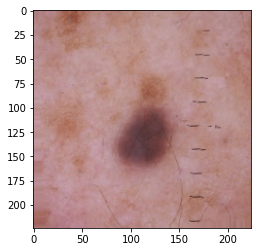

[0]


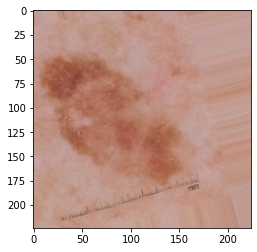

[1]


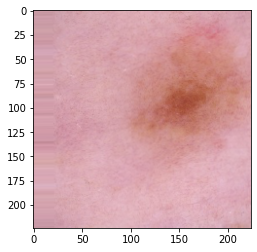

[0]


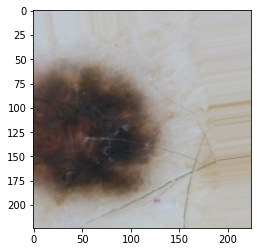

[1]


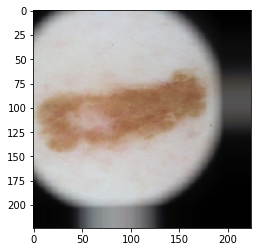

[1]


In [ ]:
#Looking at images

for x in range(5):
  image,target = train_gen.next()
  plt.imshow(np.squeeze(image))
  plt.show()
  print(target)


In [ ]:
def vgg16_model( num_classes=None):

    model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x=Flatten()(model.output)
    output=Dense(1,activation='sigmoid')(x)
    model=Model(model.input,output)
    
    return model

vgg_conv=vgg16_model(1)

In [ ]:
opt = Adam(learning_rate=1e-5)
vgg_conv.compile(loss=tfa.losses.SigmoidFocalCrossEntropy(),
                 metrics=['accuracy',tf.keras.metrics.TrueNegatives(),tf.keras.metrics.FalseNegatives(),tf.keras.metrics.TruePositives()],optimizer=opt)
vgg_conv.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
nb_epochs = 3
batch_size=8
nb_train_steps = train_df.shape[0]//batch_size
nb_val_steps=validation_df.shape[0]//batch_size
print("Number of training and validation steps: {} and {}".format(nb_train_steps,nb_val_steps))

Number of training and validation steps: 1062 and 187


Focal loss and VGG preprocessing from keras

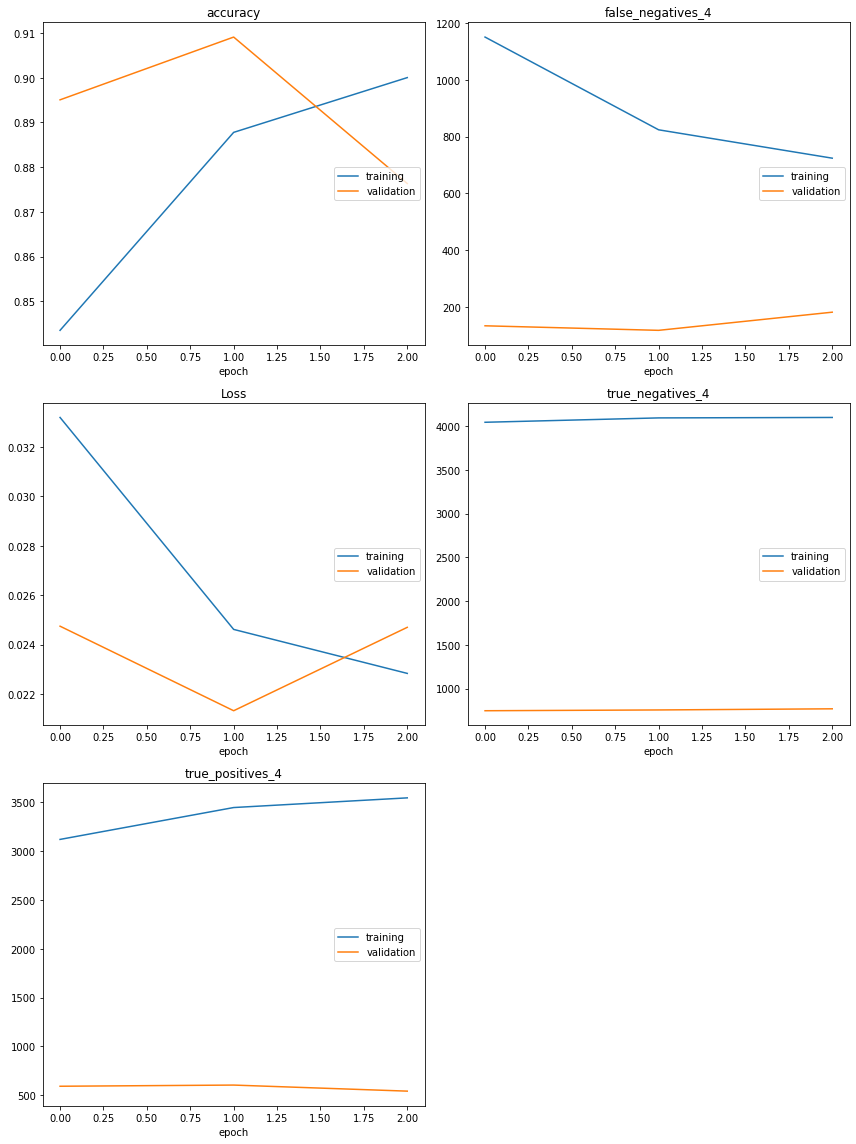

accuracy
	training         	 (min:    0.843, max:    0.900, cur:    0.900)
	validation       	 (min:    0.876, max:    0.909, cur:    0.876)
false_negatives_4
	training         	 (min:  724.000, max: 1151.000, cur:  724.000)
	validation       	 (min:  117.000, max:  181.000, cur:  181.000)
Loss
	training         	 (min:    0.023, max:    0.033, cur:    0.023)
	validation       	 (min:    0.021, max:    0.025, cur:    0.025)
true_negatives_4
	training         	 (min: 4045.000, max: 4100.000, cur: 4100.000)
	validation       	 (min:  746.000, max:  768.000, cur:  768.000)
true_positives_4
	training         	 (min: 3118.000, max: 3543.000, cur: 3543.000)
	validation       	 (min:  543.000, max:  605.000, cur:  543.000)


In [ ]:

history = vgg_conv.fit(train_gen,
          epochs=nb_epochs,
          steps_per_epoch=nb_train_steps,
          validation_data=val_gen,
          callbacks=[PlotLossesKeras()],
          validation_steps=nb_val_steps,
          verbose=0)

In [ ]:
# vgg_conv.save('model')

In [ ]:
# !zip -r /content/file.zip /content/model


In [ ]:
!chmod 600 'sample_submission.csv'

Checking models stats

In [ ]:
target=[]
for path in test_df['images']:
    img=cv2.imread(str(path))
    img = cv2.resize(img, (224,224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    img=np.reshape(img,(1,224,224,3))
    prediction=vgg_conv.predict(img)
    print(prediction)
    target.append(prediction[0][0])

submission['target']=target

[[0.12596089]]
[[0.09976521]]
[[0.06283402]]
[[0.05197835]]
[[0.16138127]]
[[0.19552262]]
[[0.16315243]]
[[0.19710308]]
[[0.16494082]]
[[0.19429561]]
[[0.12614831]]
[[0.10446206]]
[[0.14164312]]
[[0.05599396]]
[[0.23010728]]
[[0.06656584]]
[[0.1480033]]
[[0.10236542]]
[[0.23027483]]
[[0.44992834]]
[[0.17527696]]
[[0.18370719]]
[[0.1374803]]
[[0.15732832]]
[[0.53755623]]
[[0.05540318]]
[[0.06482013]]
[[0.05458441]]
[[0.14950925]]
[[0.06371957]]
[[0.07543771]]
[[0.05882866]]
[[0.15433486]]
[[0.19349883]]
[[0.2146078]]
[[0.22491416]]
[[0.08857339]]
[[0.24139263]]
[[0.10159423]]
[[0.08854211]]
[[0.13505192]]
[[0.403992]]
[[0.22735178]]
[[0.1394991]]
[[0.07973348]]
[[0.21810588]]
[[0.2906725]]
[[0.29157126]]
[[0.06543175]]
[[0.25929737]]
[[0.06385332]]
[[0.32436663]]
[[0.07993831]]
[[0.36372373]]
[[0.23144476]]
[[0.0726657]]
[[0.50610685]]
[[0.45476085]]
[[0.06458103]]
[[0.13850561]]
[[0.12525646]]
[[0.58064896]]
[[0.1574868]]
[[0.09657194]]
[[0.26653856]]
[[0.22034657]]
[[0.1148271]]
[[0.0

KeyboardInterrupt: ignored